In [1]:
# locate the root folder
CODE_DIR = '/home/ids/yuhe/Projects/CA_with_GAN/3_code_styleGAN/pSp_encoder_constructive/'

import os
os.chdir(f'{CODE_DIR}')

notebook_path = os.getcwd()
print('Current working directory is:', '\n', notebook_path) 

# import time
# import math
# from typing import Tuple, Optional, List

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from models.stylegan2_mlp import MappingNetwork, MappingNetwork_cs, MappingNetwork_cs_sparsity, EqualizedLinear
import matplotlib.pyplot as plt

Current working directory is: 
 /home/ids/yuhe/Projects/CA_with_GAN/3_code_styleGAN/pSp_encoder_constructive


In [2]:
def L1_lasso_output_regularization(output, reg_type='row'):
    if reg_type == 'row':
        return torch.sum(torch.abs(output).sum(dim=2))
    elif reg_type == 'column':
        return torch.sum(torch.abs(output).sum(dim=1))
    elif reg_type == 'element':
        return torch.sum(torch.abs(output))
    else:
        raise ValueError(f"Invalid regularization type: '{reg_type}'.")

def L1_lasso_weight_regularization(model, network='net_s', reg_type='all'):
    """
    Apply L1 regularization on the specified layers of either `net_s` or `net_c` in the model.

    Args:
        model (MappingNetwork_cs_sparsity): The model with the network to regularize.
        network (str): The network to apply Lasso regularization ('net_s' or 'net_c').
        reg_type (str): Type of weight regularization ('all' or 'last').
            - 'all': Applies Lasso to all EqualizedLinear layers in the specified network.
            - 'last': Applies Lasso only to the last EqualizedLinear layer in the specified network.

    Returns:
        torch.Tensor: Computed L1 regularization penalty for the selected layers.
    """
    lasso_weight_penalty = 0.0
    
    # Select the target network based on the network argument
    target_network = getattr(model, network, None)
    if target_network is None:
        raise ValueError(f"Invalid network '{network}'. Use 'net_s' or 'net_c'.")

    # Get layers of the selected network
    layers = list(target_network.children())

    if reg_type == 'all':
        # Apply Lasso to all EqualizedLinear layers in the target network
        for layer in layers:
            if isinstance(layer[0], EqualizedLinear):
                lasso_weight_penalty += torch.sum(torch.abs(layer[0].weight.weight))  # Access raw weight tensor
    elif reg_type == 'last':
        # Apply Lasso only to the last EqualizedLinear layer in the target network
        last_layer = layers[-1][0]
        if isinstance(last_layer, EqualizedLinear):
            lasso_weight_penalty += torch.sum(torch.abs(last_layer.weight.weight))  # Access raw weight tensor
    else:
        raise ValueError(f"Invalid reg_type '{reg_type}'. Use 'all' or 'last'.")

    return lasso_weight_penalty


def calculate_latent_loss(latent_bg_s, latent_t_s, latent_bg, latent_t, latent_bg_target, latent_t_target, 
                          lasso_output_lambda=0.01, lasso_weight_lambda=0.01, model=None, 
                          lasso_output_type='row', lasso_weight_type='all', network='net_s'):
    """
    Calculate total loss, including L1 regularization for output and weights.

    Args:
        latent_bg_s: Background latent tensor.
        latent_t_s: Target latent tensor.
        latent_bg: Background tensor.
        latent_t: Target tensor.
        latent_bg_target: Target tensor for background.
        latent_t_target: Target tensor for output.
        lasso_output_lambda: Weight for output L1 regularization.
        lasso_weight_lambda: Weight for weight L1 regularization.
        model: The model on which to apply regularization.
        lasso_output_type: Type of L1 regularization for output ('row', 'column', 'element').
        lasso_weight_type: Type of L1 regularization for weights ('all', 'last').
        network: Specifies 'net_s' or 'net_c' for weight regularization.

    Returns:
        total_loss: Computed total loss.
        loss_dict: Dictionary with individual loss components.
    """
    loss_silent_bg = F.mse_loss(latent_bg_s, torch.zeros_like(latent_bg_s))
    loss_distance_bg = F.mse_loss(latent_bg, latent_bg_target)
    loss_distance_t = F.mse_loss(latent_t, latent_t_target)
    
    lasso_output_loss = lasso_output_lambda * L1_lasso_output_regularization(latent_t_s, reg_type=lasso_output_type)
    lasso_weight_loss = (
        lasso_weight_lambda * L1_lasso_weight_regularization(model, network=network, reg_type=lasso_weight_type) 
        if model else 0.0
    )
    
    total_loss = loss_silent_bg + loss_distance_bg + loss_distance_t + lasso_output_loss + lasso_weight_loss
    return total_loss, {
        'loss_silent_bg': loss_silent_bg.item(),
        'loss_distance_bg': loss_distance_bg.item(),
        'loss_distance_t': loss_distance_t.item(),
        'lasso_output_loss': lasso_output_loss.item(),
        'lasso_weight_loss': lasso_weight_loss.item(),
        'total_loss': total_loss.item()
    }


class Options:
    def __init__(self, batch_size=4, style_dim=18, latent_dim=512, n_layers_mlp=8, zero_out_type='hard', zero_threshold=0.01,
                 lasso_output_lambda=0.1, lasso_weight_lambda=0.01, lasso_output_type='row', lasso_weight_type='all'):
        self.batch_size = batch_size
        self.style_dim = style_dim
        self.latent_dim = latent_dim
        self.n_layers_mlp = n_layers_mlp
        self.zero_out_type = zero_out_type
        self.zero_threshold = zero_threshold
        self.lasso_output_lambda = lasso_output_lambda
        self.lasso_weight_lambda = lasso_weight_lambda
        self.lasso_output_type = lasso_output_type
        self.lasso_weight_type = lasso_weight_type


def calculate_weight_sparsity(model, network='net_s', reg_type='all', zero_threshold=0.0):
    zero_count, total_count = 0, 0
    target_network = getattr(model, network, None)
    if target_network is None:
        raise ValueError(f"Invalid network '{network}'. Use 'net_s' or 'net_c'.")

    layers = list(target_network.children())
    
    if reg_type == 'all':
        for layer in layers:
            if isinstance(layer[0], EqualizedLinear):
                weights = layer[0].weight.weight
                zero_count += (weights.abs() <= zero_threshold).sum().item()
                total_count += weights.numel()
    elif reg_type == 'last':
        last_layer = layers[-1][0]
        if isinstance(last_layer, EqualizedLinear):
            weights = last_layer.weight.weight
            zero_count += (weights.abs() <= zero_threshold).sum().item()
            total_count += weights.numel()
    else:
        raise ValueError(f"Invalid reg_type '{reg_type}'. Use 'all' or 'last'.")

    sparsity = zero_count / total_count if total_count > 0 else 0
    return sparsity, zero_count, total_count

def calculate_output_sparsity(output, zero_threshold=0.0):
    """
    Calculate sparsity of output activations.

    Args:
        output (torch.Tensor): The output tensor for which sparsity is calculated.
        zero_threshold (float): Threshold below which values are considered zero.

    Returns:
        sparsity (float): The fraction of elements that are effectively zero.
        zero_count (int): Number of zero-valued elements.
        total_count (int): Total number of elements.
    """
    zero_count = (output.abs() <= zero_threshold).sum().item()   #If zero_threshold=0.0, only values that are exactly zero will be counted as sparse. For any other zero_threshold > 0, values with absolute magnitude less than or equal to the threshold will be considered sparse
    total_count = output.numel()
    sparsity = zero_count / total_count if total_count > 0 else 0
    return sparsity, zero_count, total_count


# def train_and_track_sparsity(num_epochs=100, learning_rate=0.01, zero_out_type='hard', zero_threshold=0.01, 
#                              lasso_output_lambda=0.1, lasso_weight_lambda=0.01, lasso_output_type='row', lasso_weight_type='all'):
    
#     opts = Options(batch_size=4, style_dim=18, latent_dim=512, n_layers_mlp=8, zero_out_type=zero_out_type, 
#                    zero_threshold=zero_threshold, lasso_output_lambda=lasso_output_lambda, 
#                    lasso_weight_lambda=lasso_weight_lambda, lasso_output_type=lasso_output_type, 
#                    lasso_weight_type=lasso_weight_type)
    
#     model = MappingNetwork_cs_sparsity(opts)
#     latent_bg_target = torch.randn(opts.batch_size, opts.style_dim, opts.latent_dim)
#     latent_t_target = torch.randn(opts.batch_size, opts.style_dim, opts.latent_dim)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     weight_sparsity_tracker = []
#     output_sparsity_tracker = []
#     loss_tracker = []

#     print(f"\nTraining with lasso_output_lambda = {lasso_output_lambda}, lasso_weight_lambda = {lasso_weight_lambda}, lasso_output_type = '{lasso_output_type}', lasso_weight_type = '{lasso_weight_type}'")
#     for epoch in range(num_epochs):
#         model.train()
        
#         latent_bg_c, latent_bg_s = model(latent_bg_target, zero_out_silent=False)
#         latent_t_c, latent_t_s = model(latent_t_target, zero_out_silent=True)
#         latent_bg = latent_bg_c
#         latent_t = latent_t_c + latent_t_s

#         loss, loss_dict = calculate_latent_loss(latent_bg_s, latent_t_s, latent_bg, latent_t, latent_bg_target, latent_t_target, 
#                                                 lasso_output_lambda=opts.lasso_output_lambda, lasso_weight_lambda=opts.lasso_weight_lambda, 
#                                                 model=model, lasso_output_type=lasso_output_type, lasso_weight_type=lasso_weight_type)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Track weight sparsity
#         weight_sparsity, weight_zero_count, weight_total_count = calculate_weight_sparsity(model, zero_threshold=0.0)
#         weight_sparsity_tracker.append(weight_sparsity)

#         # Track output sparsity for latent_t_s
#         output_sparsity, output_zero_count, output_total_count = calculate_output_sparsity(latent_t_s, zero_threshold=0.0)
#         output_sparsity_tracker.append(output_sparsity)

#         # Track total loss
#         loss_tracker.append(loss_dict['total_loss'])

#         if epoch % (num_epochs/10) == 0:
#             print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {loss_dict['total_loss']:.4f}, Weight Sparsity: {weight_sparsity:.4f}, Output Sparsity: {output_sparsity:.4f} ({output_zero_count} zeros out of {output_total_count})")

#     # Plot weight sparsity
#     plt.figure(figsize=(8, 5))
#     plt.plot(range(1, num_epochs + 1), weight_sparsity_tracker, marker='o', color='blue', markersize=4)
#     plt.title("Weight Sparsity Over Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("Weight Sparsity (Fraction of Near-Zero Values)")
#     plt.grid(True)
#     plt.show()

#     # Plot output sparsity
#     plt.figure(figsize=(8, 5))
#     plt.plot(range(1, num_epochs + 1), output_sparsity_tracker, marker='x', color='red', markersize=4)
#     plt.title("Output Sparsity Over Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("Output Sparsity (Fraction of Near-Zero Values)")
#     plt.grid(True)
#     plt.show()

#     # Plot total loss
#     plt.figure(figsize=(8, 5))
#     plt.plot(range(1, num_epochs + 1), loss_tracker, marker='s', color='green', markersize=4)
#     plt.title("Total Loss Over Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.grid(True)
#     plt.show()





In [3]:
# model = train_and_track_sparsity(num_epochs=100, learning_rate=0.01, zero_out_type='hard', zero_threshold=0.01, 
#                              lasso_output_lambda=0.0, lasso_weight_lambda=0.0, lasso_output_type='row', lasso_weight_type='all')



In [4]:
# Function to train and track sparsity for multiple zero_threshold values
def compare_zero_threshold_effects(threshold_values, num_epochs=100, learning_rate=0.01, zero_out_type='hard'):
    weight_sparsity_results = {}
    output_sparsity_results = {}
    loss_results = {}

    for zero_threshold in threshold_values:
        opts = Options(batch_size=4, style_dim=18, latent_dim=512, n_layers_mlp=8, zero_out_type=zero_out_type, 
                       zero_threshold=zero_threshold, lasso_output_lambda=0.0, 
                       lasso_weight_lambda=0.0, lasso_output_type='row', lasso_weight_type='all')
        
        model = MappingNetwork_cs_sparsity(opts)
        latent_bg_target = torch.randn(opts.batch_size, opts.style_dim, opts.latent_dim)
        latent_t_target = torch.randn(opts.batch_size, opts.style_dim, opts.latent_dim)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        weight_sparsity_tracker = []
        output_sparsity_tracker = []
        loss_tracker = []
        print(f"\nTraining with zero_threshold = {opts.zero_threshold}, zero_out_type = '{opts.zero_out_type}', lasso_output_lambda = {opts.lasso_output_lambda}, lasso_weight_lambda = {opts.lasso_weight_lambda}")
        for epoch in range(num_epochs):
            model.train()
            
            latent_bg_c, latent_bg_s = model(latent_bg_target, zero_out_silent=False)
            latent_t_c, latent_t_s = model(latent_t_target, zero_out_silent=True)
            latent_bg = latent_bg_c
            latent_t = latent_t_c + latent_t_s

            loss, loss_dict = calculate_latent_loss(
                latent_bg_s, latent_t_s, latent_bg, latent_t, latent_bg_target, latent_t_target, 
                lasso_output_lambda=opts.lasso_output_lambda, lasso_weight_lambda=opts.lasso_weight_lambda, 
                model=model, lasso_output_type=opts.lasso_output_type, lasso_weight_type=opts.lasso_weight_type
            )
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track weight sparsity
            weight_sparsity, weight_zero_count, weight_total_count = calculate_weight_sparsity(model, zero_threshold=0.0)
            weight_sparsity_tracker.append(weight_sparsity)

            # Track output sparsity for latent_t_s
            output_sparsity, output_zero_count, output_total_count = calculate_output_sparsity(latent_t_s, zero_threshold=0.0)
            output_sparsity_tracker.append(output_sparsity)

            # Track total loss
            loss_tracker.append(loss_dict['total_loss'])
            if epoch % (num_epochs/10) == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {loss_dict['total_loss']:.4f}, Weight Sparsity: {weight_sparsity:.4f}, Output Sparsity: {output_sparsity:.4f} ({output_zero_count} of {output_total_count})")

        weight_sparsity_results[zero_threshold] = weight_sparsity_tracker
        output_sparsity_results[zero_threshold] = output_sparsity_tracker
        loss_results[zero_threshold] = loss_tracker

    # Plot weight sparsity for all zero_thresholds
    plt.figure(figsize=(10, 6))
    for zero_threshold, sparsity_tracker in weight_sparsity_results.items():
        plt.plot(sparsity_tracker, label=f"zero_threshold={zero_threshold}")
    plt.title("Weight Sparsity Over Epochs for Different Zero Thresholds")
    plt.xlabel("Epoch")
    plt.ylabel("Weight Sparsity")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot output sparsity for all zero_thresholds
    plt.figure(figsize=(10, 6))
    for zero_threshold, sparsity_tracker in output_sparsity_results.items():
        plt.plot(sparsity_tracker, label=f"zero_threshold={zero_threshold}")
    plt.title("Output Sparsity Over Epochs for Different Zero Thresholds")
    plt.xlabel("Epoch")
    plt.ylabel("Output Sparsity")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot total loss for all zero_thresholds
    plt.figure(figsize=(10, 6))
    for zero_threshold, loss_tracker in loss_results.items():
        plt.plot(loss_tracker, label=f"zero_threshold={zero_threshold}")
    plt.title("Total Loss Over Epochs for Different Zero Thresholds")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Define different zero_threshold values to compare
zero_threshold_values = [0.0, 0.01, 0.05, 0.1]
compare_zero_threshold_effects(zero_threshold_values, num_epochs=10, zero_out_type='hard')


Training with zero_threshold = 0.0, zero_out_type = 'hard', lasso_output_lambda = 0.0, lasso_weight_lambda = 0.0
Epoch [1/10], Total Loss: 2.0144, Weight Sparsity: 0.0000, Output Sparsity: 0.0000 (0 of 36864)



Training with zero_threshold = 0.0, zero_out_type = 'soft', lasso_output_lambda = 0.0, lasso_weight_lambda = 0.0
Epoch [1/2000], Total Loss: 1.9946, Weight Sparsity: 0.0000, Output Sparsity: 0.0000 (0 of 36864)
Epoch [201/2000], Total Loss: 0.2299, Weight Sparsity: 0.0000, Output Sparsity: 0.0000 (0 of 36864)
Epoch [401/2000], Total Loss: 0.0511, Weight Sparsity: 0.0000, Output Sparsity: 0.0000 (0 of 36864)
Epoch [601/2000], Total Loss: 0.0174, Weight Sparsity: 0.0000, Output Sparsity: 0.0000 (0 of 36864)
Epoch [801/2000], Total Loss: 0.0027, Weight Sparsity: 0.0000, Output Sparsity: 0.0000 (0 of 36864)
Epoch [1001/2000], Total Loss: 0.0048, Weight Sparsity: 0.0000, Output Sparsity: 0.0000 (0 of 36864)
Epoch [1201/2000], Total Loss: 0.0125, Weight Sparsity: 0.0000, Output Sparsity: 0.0000 (0 of 36864)
Epoch [1401/2000], Total Loss: 0.0013, Weight Sparsity: 0.0000, Output Sparsity: 0.0000 (0 of 36864)
Epoch [1601/2000], Total Loss: 0.0011, Weight Sparsity: 0.0000, Output Sparsity: 0.00

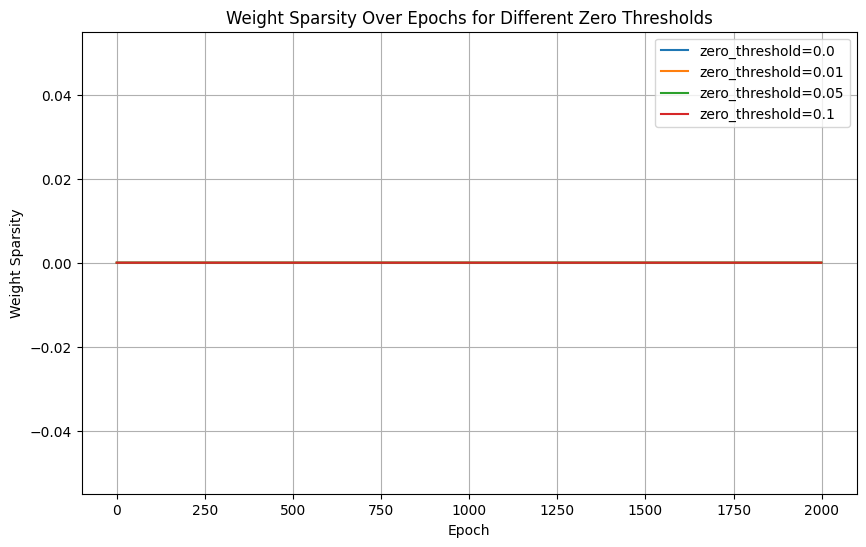

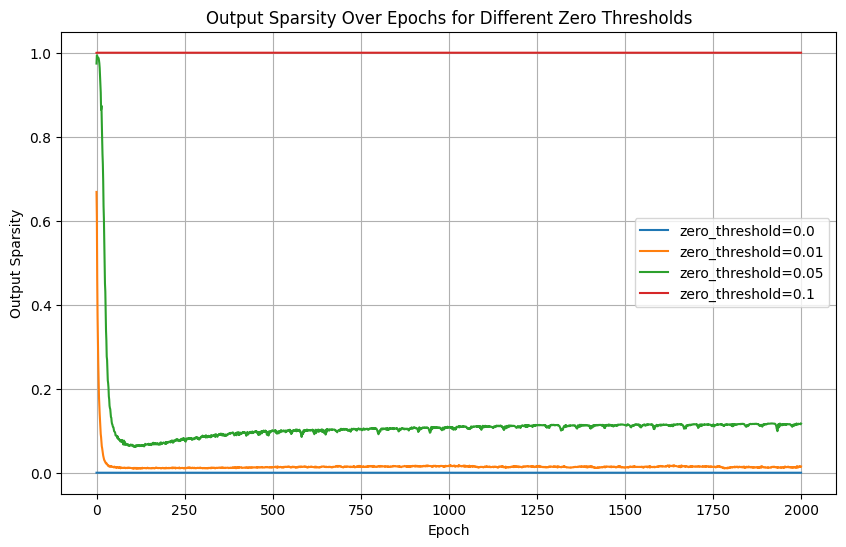

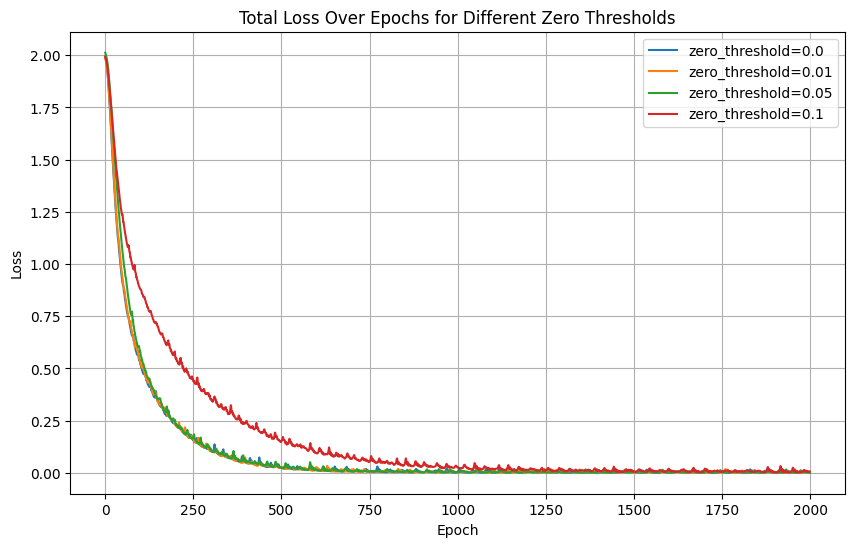

In [6]:
# Define different zero_threshold values to compare
zero_threshold_values = [0.0, 0.01, 0.05, 0.1]
compare_zero_threshold_effects(zero_threshold_values, num_epochs=2000, zero_out_type='soft')